
Successfully saved authorization token.
Number of images: 22
Processed image 1/22
Processed image 2/22
Processed image 3/22
Processed image 4/22
Processed image 5/22
Processed image 6/22
Processed image 7/22
Processed image 8/22
Processed image 9/22
Processed image 10/22
Processed image 11/22
Processed image 12/22
Processed image 13/22
Processed image 14/22
Processed image 15/22
Processed image 16/22
Processed image 17/22
Processed image 18/22
Processed image 19/22
Processed image 20/22
Processed image 21/22
Processed image 22/22
Total samples: 36799


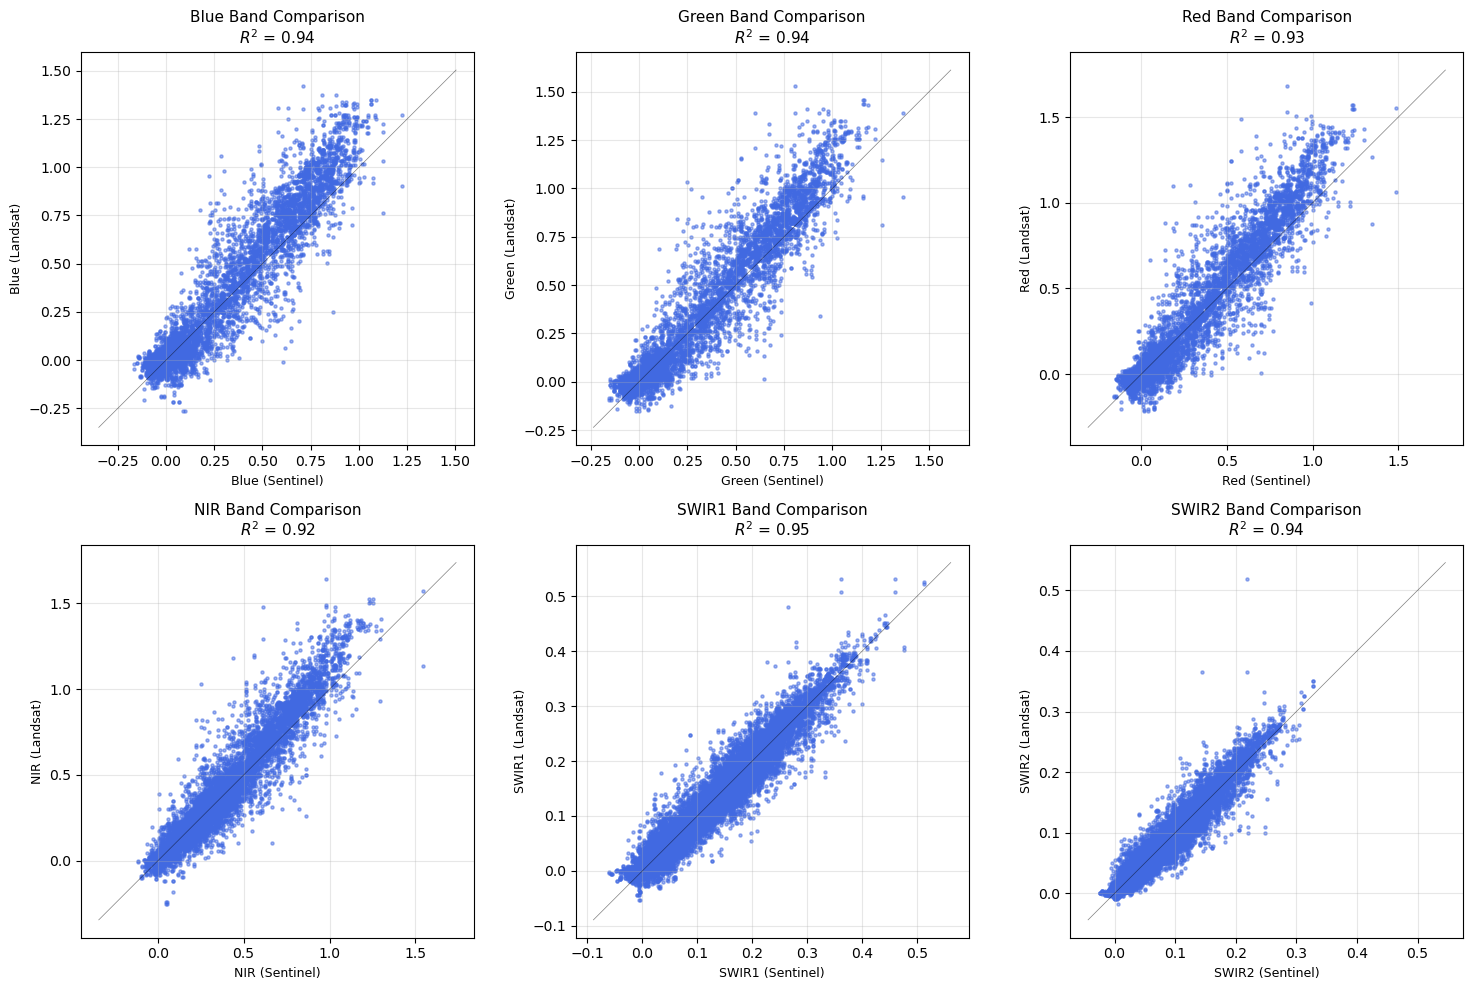

In [2]:
import ee
import geopandas as gpd
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Initialize the Earth Engine API.
ee.Authenticate()
ee.Initialize()

# -----------------------------
# 1. Load your AOI from a shapefile
# -----------------------------
shp_path = r"C:\Users\konst\Documents\Hiwi\mw3\drought_indicies\data\Untersuchungsgebiete\002a_Sen1-Subset_Eifel.shp"
gdf = gpd.read_file(shp_path)
geojson = gdf.to_json()
aoi = ee.Geometry(json.loads(geojson)['features'][0]['geometry'])

# -----------------------------
# 2. Define date range and cloud mask function
# -----------------------------
start_date = '2013-01-01'
end_date   = '2025-01-31'

def mask_clouds(image):
    fmask = image.select('Fmask')
    cloud_bit = fmask.rightShift(1).bitwiseAnd(1)
    shadow_bit = fmask.rightShift(3).bitwiseAnd(1)
    mask = cloud_bit.eq(0).And(shadow_bit.eq(0))
    return image.updateMask(mask)

# -----------------------------
# 3. Load and filter the two HLS collections (Sentinel and Landsat)
# -----------------------------
hlss30 = (ee.ImageCollection('NASA/HLS/HLSS30/v002')
          .filterBounds(aoi)
          .filterDate(start_date, end_date)
          .map(mask_clouds))
hlsl30 = (ee.ImageCollection('NASA/HLS/HLSL30/v002')
          .filterBounds(aoi)
          .filterDate(start_date, end_date)
          .map(mask_clouds))

# Rename bands for consistency
hlss30_renamed = hlss30.map(lambda img: img.select(
    ['B2', 'B3', 'B4', 'B8A', 'B11', 'B12', 'B10', 'Fmask'],
    ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'Cirrus', 'Fmask']
))
hlsl30_renamed = hlsl30.map(lambda img: img.select(
    ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9', 'Fmask'],
    ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'Cirrus', 'Fmask']
))

# -----------------------------
# 4. Join the two collections with a 30-minute tolerance
# -----------------------------
thirty_min_millis = 1000 * 60 * 30  # 30 minutes in milliseconds
dateFilter = ee.Filter.maxDifference(
    difference=thirty_min_millis,
    leftField='system:time_start',
    rightField='system:time_start'
)
join = ee.Join.inner()
joined_collection = join.apply(hlss30_renamed, hlsl30_renamed, dateFilter)

# -----------------------------
# 5. Merge each joined pair into one image and force clean band names
# -----------------------------
def merge_images(joined_feature):
    sentinel_img = ee.Image(joined_feature.get('primary'))
    landsat_img  = ee.Image(joined_feature.get('secondary'))
    
    sentinel_renamed = sentinel_img.select(
        ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2'],
        ['Blue_S', 'Green_S', 'Red_S', 'NIR_S', 'SWIR1_S', 'SWIR2_S']
    )
    landsat_renamed = landsat_img.select(
        ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2'],
        ['Blue_L', 'Green_L', 'Red_L', 'NIR_L', 'SWIR1_L', 'SWIR2_L']
    )
    combined = sentinel_renamed.addBands(landsat_renamed)
    combined = combined.select(combined.bandNames())
    
    return combined.set('system:time_start', sentinel_img.get('system:time_start'))

combined_collection = joined_collection.map(merge_images)

# -----------------------------
# 6. Calculate the percentage of valid pixels for each image
# -----------------------------
def calculate_valid_percentage(image):
    image = ee.Image(image)
    blue_s = image.select('Blue_S')
    blue_l = image.select('Blue_L')
    
    valid_mask = blue_s.mask().And(blue_l.mask()).rename('mask')
    valid_percent_dict = valid_mask.reduceRegion(
         reducer=ee.Reducer.mean(),
         geometry=aoi,
         scale=30,
         maxPixels=1e9
    )
    valid_percent = ee.Number(valid_percent_dict.get('mask')).multiply(100)
    return image.set('valid_percent', valid_percent)

combined_collection_with_percent = combined_collection.map(calculate_valid_percentage)

# -----------------------------
# 7. Filter images with at least 60% valid data and process all images
# -----------------------------
filtered_collection = combined_collection_with_percent.filter(
    ee.Filter.gte('valid_percent', 60)
)

# Get the number of images and convert to list
num_images = filtered_collection.size().getInfo()
print("Number of images:", num_images)
image_list = filtered_collection.toList(num_images)

# Initialize data dictionary
data = {
    'Blue_S': [], 'Blue_L': [],
    'Green_S': [], 'Green_L': [],
    'Red_S': [], 'Red_L': [],
    'NIR_S': [], 'NIR_L': [],
    'SWIR1_S': [], 'SWIR1_L': [],
    'SWIR2_S': [], 'SWIR2_L': []
}

# Process each image
for i in range(num_images):
    image = ee.Image(image_list.get(i))
    sample_points = image.sample(
        region=aoi,
        scale=30,
        numPixels=2000,
        seed=42  # Consistent seed for reproducibility
    )
    sample_dict = sample_points.getInfo()
    features = sample_dict['features']
    
    for f in features:
        props = f['properties']
        data['Blue_S'].append(props.get('Blue_S'))
        data['Blue_L'].append(props.get('Blue_L'))
        data['Green_S'].append(props.get('Green_S'))
        data['Green_L'].append(props.get('Green_L'))
        data['Red_S'].append(props.get('Red_S'))
        data['Red_L'].append(props.get('Red_L'))
        data['NIR_S'].append(props.get('NIR_S'))
        data['NIR_L'].append(props.get('NIR_L'))
        data['SWIR1_S'].append(props.get('SWIR1_S'))
        data['SWIR1_L'].append(props.get('SWIR1_L'))
        data['SWIR2_S'].append(props.get('SWIR2_S'))
        data['SWIR2_L'].append(props.get('SWIR2_L'))
    
    print(f"Processed image {i+1}/{num_images}")

# Create DataFrame and plot
df = pd.DataFrame(data)
print("Total samples:", len(df))

bands = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Adjust spacing

for idx, band in enumerate(bands):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Calculate statistics
    r = df[f'{band}_S'].corr(df[f'{band}_L'])
    r2 = r ** 2
    
    # Create scatter plot
    ax.scatter(df[f'{band}_S'], df[f'{band}_L'], 
               s=5, alpha=0.5, color='royalblue')
    
    # Add labels and title
    ax.set_xlabel(f'{band} (Sentinel)', fontsize=9)
    ax.set_ylabel(f'{band} (Landsat)', fontsize=9)
    ax.set_title(f'{band} Band Comparison\n$R^2$ = {r2:.2f}', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Add diagonal line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.5, lw=0.5)
    ax.set_aspect('equal')

# Final adjustments
plt.tight_layout()
plt.show()